# Observational trigger optimization

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [225]:
import math

import numpy as np
import pandas as pd
import ocha_stratus as stratus
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import FuncFormatter
from tqdm.auto import tqdm

from src.datasources import ibtracs
from src.constants import *

In [8]:
df_storms = ibtracs.load_storms()

In [26]:
df_storms

,storm_id,sid,atcf_id,season,number,name,provisional,created_at
0,0eae9884-5a95-427e-813f-24b6948adfc8,1842298N11080,None,1842,1,UNNAMED,False,2025-05-13 23:12:11.828324
1,654c51b2-e783-4ebc-9089-d760f2550a19,1845336N10074,None,1845,1,UNNAMED,False,2025-05-13 23:12:11.828324
2,78e5587a-6792-4336-81f3-ab3a2fda026c,1848011S09079,None,1848,1,UNNAMED,False,2025-05-13 23:12:11.828324
3,fb2cdc51-02c3-42a2-a22a-5a9dd37da2c7,1848011S09080,None,1848,2,UNNAMED,False,2025-05-13 23:12:11.828324
4,3a0add51-96ee-4a7f-934d-bf0f599673ed,1848011S15057,None,1848,3,UNNAMED,False,2025-05-13 23:12:11.828324
...,...,...,...,...,...,...,...,...
13441,558cd6fb-427b-48d3-aceb-6c0dd51d6697,2025087S14124,SH282025,2025,21,DIANNE,True,2025-05-13 23:12:11.828324
13442,7a4ebb5f-3060-4640-8f1d-3688841b73bc,2025102S11128,SH292025,2025,22,ERROL,True,2025-05-13 23:12:11.828324
13443,73d722e0-b56b-4878-ab91-2e4cb789fe56,2025104S15168,SH302025,2025,23,TAM,True,2025-05-13 23:12:11.828324
13444,b70c74fd-db31-4851-87f0-ab47c6bcbbb7,2025108S11140,SH312025,2025,24,UNNAMED,True,2025-05-13 23:12:11.828324


In [34]:
df_storms["name_season"] = (
    df_storms["name"].str.capitalize() + " " + df_storms["season"].astype(str)
)

In [11]:
blob_name = (
    f"{PROJECT_PREFIX}/processed/storm_stats/zma_stats_imerg_quantiles.parquet"
)

df_stats_raw = stratus.load_parquet_from_blob(blob_name)

In [187]:
blob_name = f"{PROJECT_PREFIX}/processed/impact/emdat_cerf_upto2024.parquet"
df_impact = stratus.load_parquet_from_blob(blob_name)
df_impact["cerf"] = ~df_impact["Amount in US$"].isnull()
cols = ["sid", "cerf", "Total Affected", "Amount in US$"]
df_impact = df_impact[cols]

In [192]:
df_stats = df_stats_raw.merge(df_impact, how="left").merge(
    df_storms[["sid", "season", "name", "name_season"]], how="left"
)


def set_cerf(row):
    if row["season"] < 2006:
        return np.nan
    else:
        if row["cerf"] == True:
            return True
        else:
            return False


df_stats["cerf"] = df_stats.apply(set_cerf, axis=1)
df_stats["cerf_str"] = df_stats["cerf"].astype(str)
df_stats["Total Affected"] = df_stats["Total Affected"].fillna(0).astype(int)
df_stats

,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll2_mean_abv,q99_roll3,q99_roll3_mean_abv,cerf,Total Affected,Amount in US$,season,name,name_season,cerf_str
0,2000233N12316,2000-08-24 00:00:00.000040,2000-08-24 12:00:00.000040,40.0,NaN,18.190000,35.262634,18.152500,34.911701,18.189999,...,70.659996,66.406700,70.882492,NaN,0,NaN,2000,DEBBY,Debby 2000,nan
1,2000260N15308,2000-09-19 12:00:00.000040,2000-09-20 18:00:00.000040,30.0,NaN,26.412498,68.799995,21.250000,62.718685,23.750000,...,181.145996,173.454788,184.656494,NaN,0,NaN,2000,HELENE,Helene 2000,nan
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,395.611481,390.244812,404.398499,NaN,5900012,NaN,2001,MICHELLE,Michelle 2001,nan
3,2002258N10300,2002-09-19 18:00:00.000040,2002-09-21 18:00:00.000040,110.0,75.0,78.592495,207.540146,40.644997,143.821213,56.139999,...,694.172974,724.066223,794.184509,NaN,42500,NaN,2002,ISIDORE,Isidore 2002,nan
4,2002265N10315,2002-09-29 00:00:00.000040,2002-10-02 00:00:00.000040,90.0,90.0,54.195000,89.869759,37.119995,67.565186,43.507500,...,176.249969,160.742477,183.679001,NaN,281470,NaN,2002,LILI,Lili 2002,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2023321N15278,2023-11-18 00:00:00.000039,2023-11-18 00:00:00.000039,30.0,NaN,3.947500,38.300976,3.947500,38.281227,3.947500,...,161.707001,154.484039,161.707001,False,0,NaN,2023,UNNAMED,Unnamed 2023,False
58,2024216N20284,2024-08-02 12:00:00.000039,2024-08-04 00:00:00.000039,35.0,30.0,54.164997,103.377747,40.412502,75.217384,49.295002,...,233.986496,222.375443,240.353485,False,0,NaN,2024,DEBBY,Debby 2024,False
59,2024268N17278,2024-09-25 12:00:00.000039,2024-09-25 12:00:00.000039,65.0,NaN,25.417499,116.488297,21.440001,99.156189,25.417500,...,265.378998,282.273987,307.214508,False,0,NaN,2024,HELENE,Helene 2024,False
60,2024293N21294,2024-10-20 06:00:00.000039,2024-10-22 06:00:00.000039,75.0,75.0,12.205000,61.957958,9.135000,50.185165,12.029999,...,509.317963,435.983795,533.183960,True,320000,3499569.0,2024,OSCAR,Oscar 2024,True


In [193]:
target_rp = 4
total_years = 2024 - 2000 + 1
target_year_count = math.floor((total_years + 1) / target_rp)

In [194]:
target_year_count

6

In [195]:
total_affected_thresh = None
for total_affected in sorted(df_stats["Total Affected"], reverse=True):
    dff = df_stats[df_stats["Total Affected"] >= total_affected]
    display(dff)
    print(total_affected)
    if dff["season"].nunique() <= target_year_count:
        total_affected_thresh = total_affected
    else:
        break

,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll2_mean_abv,q99_roll3,q99_roll3_mean_abv,cerf,Total Affected,Amount in US$,season,name,name_season,cerf_str
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.57999,170.772461,86.267494,140.139038,100.352501,...,275.960999,249.44754,298.256531,True,10000000,7999469.0,2017,IRMA,Irma 2017,True


10000000


,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll2_mean_abv,q99_roll3,q99_roll3_mean_abv,cerf,Total Affected,Amount in US$,season,name,name_season,cerf_str
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,395.611481,390.244812,404.398499,NaN,5900012,NaN,2001,MICHELLE,Michelle 2001,nan
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.579990,170.772461,86.267494,140.139038,100.352501,...,275.960999,249.447540,298.256531,True,10000000,7999469.0,2017,IRMA,Irma 2017,True


5900012


,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll2_mean_abv,q99_roll3,q99_roll3_mean_abv,cerf,Total Affected,Amount in US$,season,name,name_season,cerf_str
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,395.611481,390.244812,404.398499,NaN,5900012,NaN,2001,MICHELLE,Michelle 2001,nan
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.579990,170.772461,86.267494,140.139038,100.352501,...,275.960999,249.447540,298.256531,True,10000000,7999469.0,2017,IRMA,Irma 2017,True
61,2024309N13283,2024-11-06 06:00:00.000039,2024-11-07 06:00:00.000039,100.0,100.0,39.124998,102.100563,34.349998,83.028404,37.614998,...,252.553986,253.055435,287.727478,True,4000000,5999888.0,2024,RAFAEL,Rafael 2024,True


4000000


,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll2_mean_abv,q99_roll3,q99_roll3_mean_abv,cerf,Total Affected,Amount in US$,season,name,name_season,cerf_str
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,395.611481,390.244812,404.398499,NaN,5900012,NaN,2001,MICHELLE,Michelle 2001,nan
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.579990,170.772461,86.267494,140.139038,100.352501,...,275.960999,249.447540,298.256531,True,10000000,7999469.0,2017,IRMA,Irma 2017,True
54,2022266N12294,2022-09-27 00:00:00.000039,2022-09-27 18:00:00.000039,110.0,110.0,56.504995,107.042099,47.079998,94.006348,56.504997,...,189.854980,173.888687,192.505981,True,3200000,7827734.0,2022,IAN,Ian 2022,True
61,2024309N13283,2024-11-06 06:00:00.000039,2024-11-07 06:00:00.000039,100.0,100.0,39.124998,102.100563,34.349998,83.028404,37.614998,...,252.553986,253.055435,287.727478,True,4000000,5999888.0,2024,RAFAEL,Rafael 2024,True


3200000


,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll2_mean_abv,q99_roll3,q99_roll3_mean_abv,cerf,Total Affected,Amount in US$,season,name,name_season,cerf_str
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,395.611481,390.244812,404.398499,NaN,5900012,NaN,2001,MICHELLE,Michelle 2001,nan
11,2005186N12299,2005-07-08 00:00:00.000039,2005-07-09 06:00:00.000039,130.0,120.0,101.397491,172.256393,87.290009,153.847000,93.629997,...,361.002991,317.722046,366.965973,NaN,2500000,NaN,2005,DENNIS,Dennis 2005,nan
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.579990,170.772461,86.267494,140.139038,100.352501,...,275.960999,249.447540,298.256531,True,10000000,7999469.0,2017,IRMA,Irma 2017,True
54,2022266N12294,2022-09-27 00:00:00.000039,2022-09-27 18:00:00.000039,110.0,110.0,56.504995,107.042099,47.079998,94.006348,56.504997,...,189.854980,173.888687,192.505981,True,3200000,7827734.0,2022,IAN,Ian 2022,True
61,2024309N13283,2024-11-06 06:00:00.000039,2024-11-07 06:00:00.000039,100.0,100.0,39.124998,102.100563,34.349998,83.028404,37.614998,...,252.553986,253.055435,287.727478,True,4000000,5999888.0,2024,RAFAEL,Rafael 2024,True


2500000


,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll2_mean_abv,q99_roll3,q99_roll3_mean_abv,cerf,Total Affected,Amount in US$,season,name,name_season,cerf_str
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,395.611481,390.244812,404.398499,NaN,5900012,NaN,2001,MICHELLE,Michelle 2001,nan
11,2005186N12299,2005-07-08 00:00:00.000039,2005-07-09 06:00:00.000039,130.0,120.0,101.397491,172.256393,87.290009,153.847000,93.629997,...,361.002991,317.722046,366.965973,NaN,2500000,NaN,2005,DENNIS,Dennis 2005,nan
22,2008238N13293,2008-08-27 06:00:00.000039,2008-08-31 06:00:00.000039,135.0,120.0,68.070000,93.134293,45.957497,70.283768,52.404999,...,132.113007,127.646782,145.845490,False,450019,NaN,2008,GUSTAV,Gustav 2008,False
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.579990,170.772461,86.267494,140.139038,100.352501,...,275.960999,249.447540,298.256531,True,10000000,7999469.0,2017,IRMA,Irma 2017,True
54,2022266N12294,2022-09-27 00:00:00.000039,2022-09-27 18:00:00.000039,110.0,110.0,56.504995,107.042099,47.079998,94.006348,56.504997,...,189.854980,173.888687,192.505981,True,3200000,7827734.0,2022,IAN,Ian 2022,True
61,2024309N13283,2024-11-06 06:00:00.000039,2024-11-07 06:00:00.000039,100.0,100.0,39.124998,102.100563,34.349998,83.028404,37.614998,...,252.553986,253.055435,287.727478,True,4000000,5999888.0,2024,RAFAEL,Rafael 2024,True


450019


,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll2_mean_abv,q99_roll3,q99_roll3_mean_abv,cerf,Total Affected,Amount in US$,season,name,name_season,cerf_str
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,395.611481,390.244812,404.398499,NaN,5900012,NaN,2001,MICHELLE,Michelle 2001,nan
11,2005186N12299,2005-07-08 00:00:00.000039,2005-07-09 06:00:00.000039,130.0,120.0,101.397491,172.256393,87.290009,153.847000,93.629997,...,361.002991,317.722046,366.965973,NaN,2500000,NaN,2005,DENNIS,Dennis 2005,nan
22,2008238N13293,2008-08-27 06:00:00.000039,2008-08-31 06:00:00.000039,135.0,120.0,68.070000,93.134293,45.957497,70.283768,52.404999,...,132.113007,127.646782,145.845490,False,450019,NaN,2008,GUSTAV,Gustav 2008,False
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.579990,170.772461,86.267494,140.139038,100.352501,...,275.960999,249.447540,298.256531,True,10000000,7999469.0,2017,IRMA,Irma 2017,True
54,2022266N12294,2022-09-27 00:00:00.000039,2022-09-27 18:00:00.000039,110.0,110.0,56.504995,107.042099,47.079998,94.006348,56.504997,...,189.854980,173.888687,192.505981,True,3200000,7827734.0,2022,IAN,Ian 2022,True
60,2024293N21294,2024-10-20 06:00:00.000039,2024-10-22 06:00:00.000039,75.0,75.0,12.205000,61.957958,9.135000,50.185165,12.029999,...,509.317963,435.983795,533.183960,True,320000,3499569.0,2024,OSCAR,Oscar 2024,True
61,2024309N13283,2024-11-06 06:00:00.000039,2024-11-07 06:00:00.000039,100.0,100.0,39.124998,102.100563,34.349998,83.028404,37.614998,...,252.553986,253.055435,287.727478,True,4000000,5999888.0,2024,RAFAEL,Rafael 2024,True


320000


,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll2_mean_abv,q99_roll3,q99_roll3_mean_abv,cerf,Total Affected,Amount in US$,season,name,name_season,cerf_str
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,395.611481,390.244812,404.398499,NaN,5900012,NaN,2001,MICHELLE,Michelle 2001,nan
4,2002265N10315,2002-09-29 00:00:00.000040,2002-10-02 00:00:00.000040,90.0,90.0,54.195000,89.869759,37.119995,67.565186,43.507500,...,176.249969,160.742477,183.679001,NaN,281470,NaN,2002,LILI,Lili 2002,nan
11,2005186N12299,2005-07-08 00:00:00.000039,2005-07-09 06:00:00.000039,130.0,120.0,101.397491,172.256393,87.290009,153.847000,93.629997,...,361.002991,317.722046,366.965973,NaN,2500000,NaN,2005,DENNIS,Dennis 2005,nan
22,2008238N13293,2008-08-27 06:00:00.000039,2008-08-31 06:00:00.000039,135.0,120.0,68.070000,93.134293,45.957497,70.283768,52.404999,...,132.113007,127.646782,145.845490,False,450019,NaN,2008,GUSTAV,Gustav 2008,False
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.579990,170.772461,86.267494,140.139038,100.352501,...,275.960999,249.447540,298.256531,True,10000000,7999469.0,2017,IRMA,Irma 2017,True
54,2022266N12294,2022-09-27 00:00:00.000039,2022-09-27 18:00:00.000039,110.0,110.0,56.504995,107.042099,47.079998,94.006348,56.504997,...,189.854980,173.888687,192.505981,True,3200000,7827734.0,2022,IAN,Ian 2022,True
60,2024293N21294,2024-10-20 06:00:00.000039,2024-10-22 06:00:00.000039,75.0,75.0,12.205000,61.957958,9.135000,50.185165,12.029999,...,509.317963,435.983795,533.183960,True,320000,3499569.0,2024,OSCAR,Oscar 2024,True
61,2024309N13283,2024-11-06 06:00:00.000039,2024-11-07 06:00:00.000039,100.0,100.0,39.124998,102.100563,34.349998,83.028404,37.614998,...,252.553986,253.055435,287.727478,True,4000000,5999888.0,2024,RAFAEL,Rafael 2024,True


281470


In [196]:
total_affected_thresh

320000

In [197]:
df_stats["target"] = df_stats["Total Affected"] >= total_affected_thresh

In [415]:
df_stats["target_with_cerf"] = df_stats["target"] | df_stats["cerf"]

In [417]:
df_stats[df_stats["target_with_cerf"]]

,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll3_mean_abv,cerf,Total Affected,Amount in US$,season,name,name_season,cerf_str,target,target_with_cerf
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,404.398499,NaN,5900012,NaN,2001,MICHELLE,Michelle 2001,nan,True,True
11,2005186N12299,2005-07-08 00:00:00.000039,2005-07-09 06:00:00.000039,130.0,120.0,101.397491,172.256393,87.290009,153.847000,93.629997,...,366.965973,NaN,2500000,NaN,2005,DENNIS,Dennis 2005,nan,True,True
22,2008238N13293,2008-08-27 06:00:00.000039,2008-08-31 06:00:00.000039,135.0,120.0,68.070000,93.134293,45.957497,70.283768,52.404999,...,145.845490,False,450019,NaN,2008,GUSTAV,Gustav 2008,False,True,True
35,2012296N14283,2012-10-25 00:00:00.000039,2012-10-25 12:00:00.000039,100.0,100.0,79.467499,156.255432,58.065002,139.154907,79.467499,...,292.683472,True,162605,5522753.0,2012,SANDY,Sandy 2012,True,False,True
38,2016273N13300,2016-10-04 18:00:00.000039,2016-10-05 18:00:00.000039,120.0,115.0,25.622500,127.108154,17.419998,95.043182,20.857498,...,475.744476,True,190000,5352736.0,2016,MATTHEW,Matthew 2016,True,False,True
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.579990,170.772461,86.267494,140.139038,100.352501,...,298.256531,True,10000000,7999469.0,2017,IRMA,Irma 2017,True,True,True
54,2022266N12294,2022-09-27 00:00:00.000039,2022-09-27 18:00:00.000039,110.0,110.0,56.504995,107.042099,47.079998,94.006348,56.504997,...,192.505981,True,3200000,7827734.0,2022,IAN,Ian 2022,True,True,True
60,2024293N21294,2024-10-20 06:00:00.000039,2024-10-22 06:00:00.000039,75.0,75.0,12.205000,61.957958,9.135000,50.185165,12.029999,...,533.183960,True,320000,3499569.0,2024,OSCAR,Oscar 2024,True,True,True
61,2024309N13283,2024-11-06 06:00:00.000039,2024-11-07 06:00:00.000039,100.0,100.0,39.124998,102.100563,34.349998,83.028404,37.614998,...,287.727478,True,4000000,5999888.0,2024,RAFAEL,Rafael 2024,True,True,True


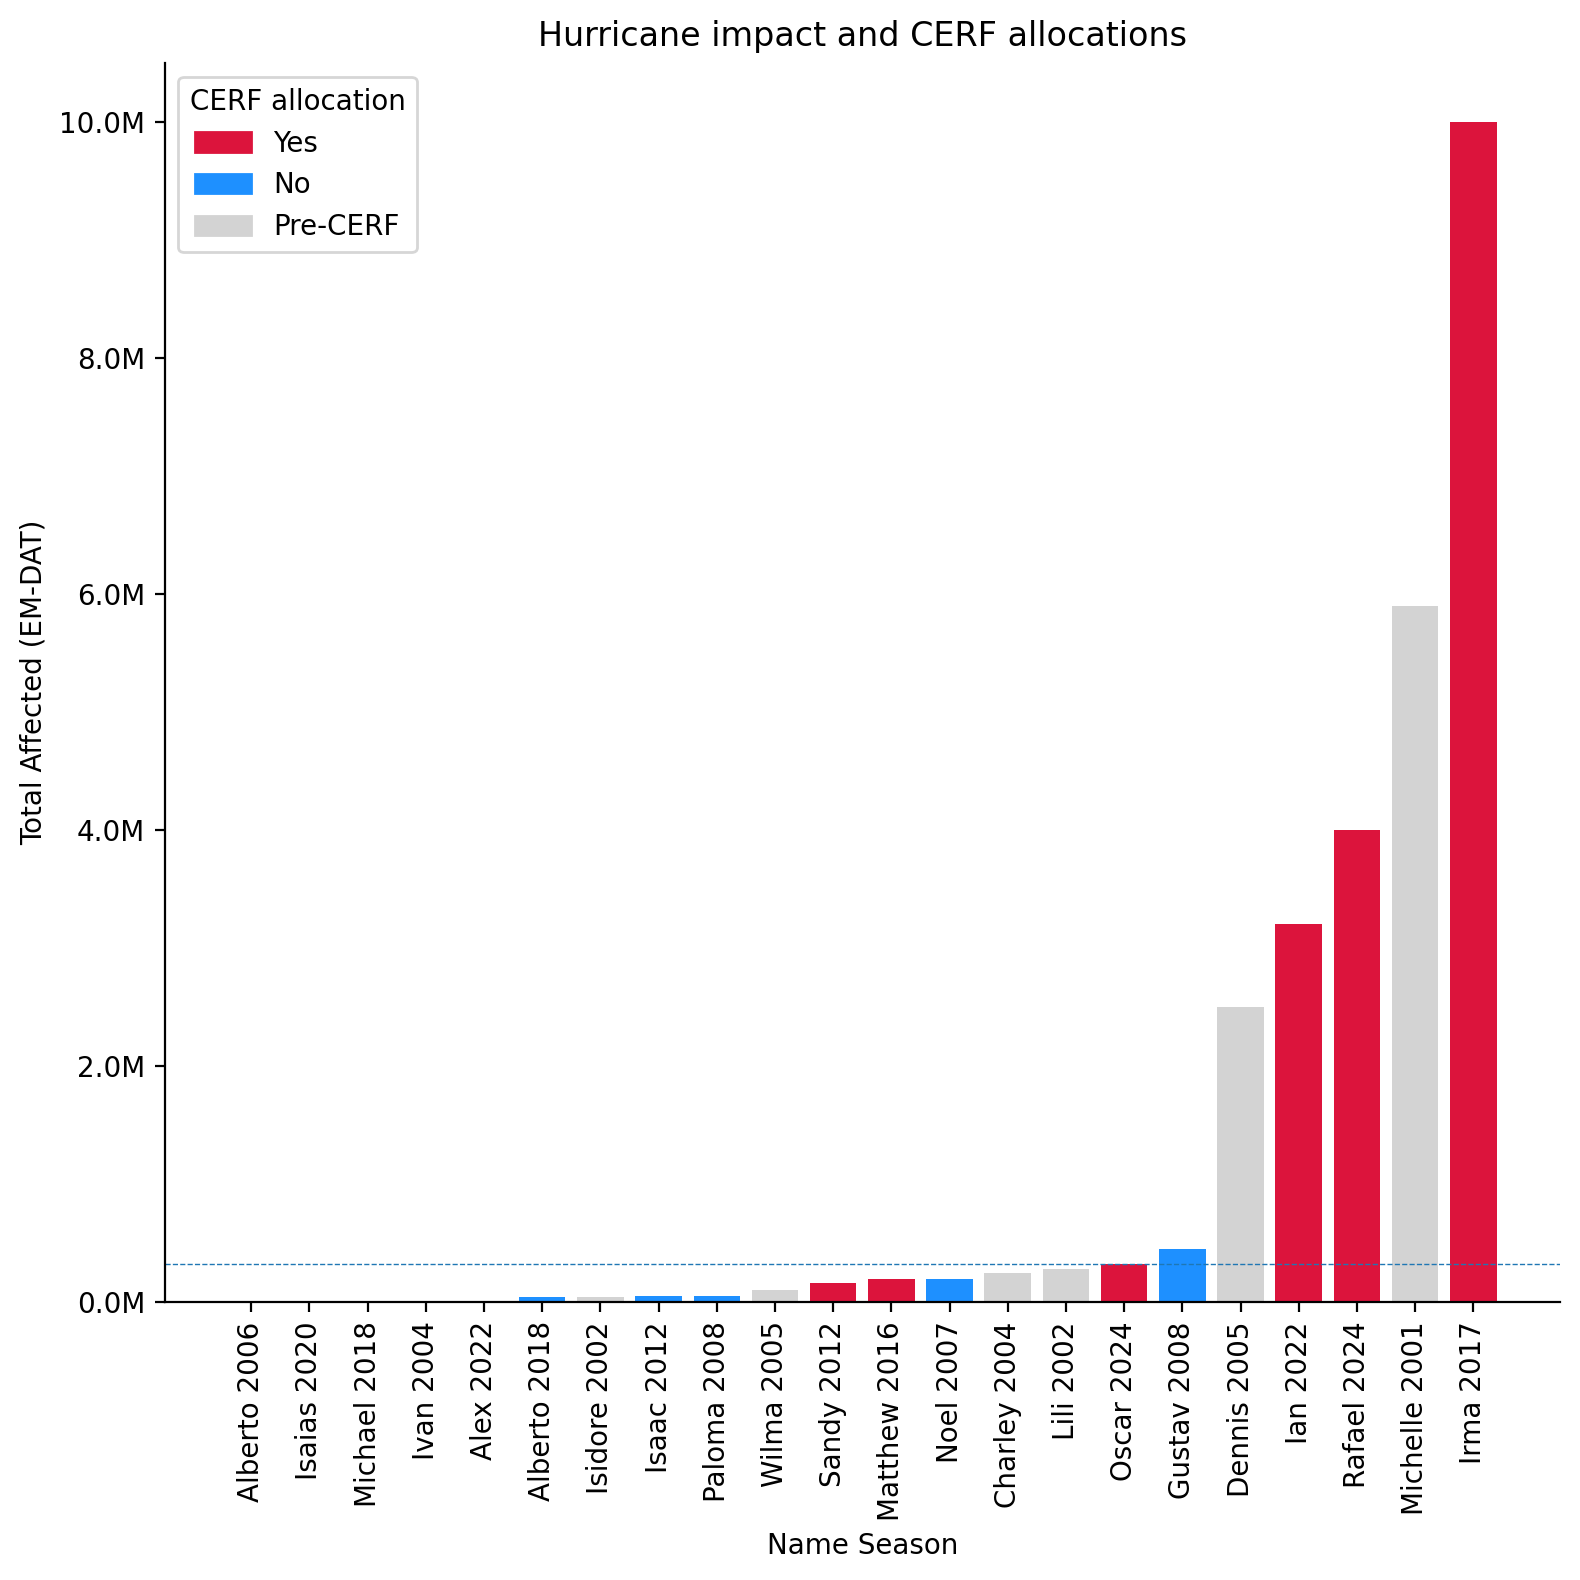

In [418]:
df_plot = df_stats[df_stats["Total Affected"] > 0].sort_values(
    "Total Affected", ascending=True
)

cerf_color = "crimson"
noncerf_color = "dodgerblue"
precerf_color = "lightgrey"

# Set bar colors: red if cerf is True, else blue
colors = df_plot["cerf_str"].map(
    {"True": cerf_color, "False": noncerf_color, "nan": precerf_color}
)

# Plot
fig, ax = plt.subplots(figsize=(8, 8), dpi=200)
ax.bar(df_plot["name_season"], df_plot["Total Affected"], color=colors)

# Formatting
ax.set_ylabel("Total Affected (EM-DAT)")
ax.set_xlabel("Name Season")
ax.set_title("Hurricane impact and CERF allocations")
ax.tick_params(axis="x", rotation=90)

ax.axhline(total_affected_thresh, linewidth=0.5, linestyle="--")

ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x/1e6:.1f}M"))

ax.legend(
    handles=[
        mpatches.Patch(color=cerf_color, label="Yes"),
        mpatches.Patch(color=noncerf_color, label="No"),
        mpatches.Patch(color=precerf_color, label="Pre-CERF"),
    ],
    title="CERF allocation",
)

ax.spines.top.set_visible(False)
ax.spines.right.set_visible(False)

plt.tight_layout()

In [419]:
cerf_year_count = df_stats[df_stats["cerf"] == True]["season"].nunique()

In [420]:
cerf_total_years = 2024 - 2006 + 1

In [421]:
cerf_rp = (cerf_total_years + 1) / cerf_year_count

In [422]:
cerf_rp

4.0

In [423]:
df_stats["Amount in US$"].mean()

np.float64(6033691.5)

In [424]:
df_stats

,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll3_mean_abv,cerf,Total Affected,Amount in US$,season,name,name_season,cerf_str,target,target_with_cerf
0,2000233N12316,2000-08-24 00:00:00.000040,2000-08-24 12:00:00.000040,40.0,NaN,18.190000,35.262634,18.152500,34.911701,18.189999,...,70.882492,NaN,0,NaN,2000,DEBBY,Debby 2000,nan,False,False
1,2000260N15308,2000-09-19 12:00:00.000040,2000-09-20 18:00:00.000040,30.0,NaN,26.412498,68.799995,21.250000,62.718685,23.750000,...,184.656494,NaN,0,NaN,2000,HELENE,Helene 2000,nan,False,False
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,404.398499,NaN,5900012,NaN,2001,MICHELLE,Michelle 2001,nan,True,True
3,2002258N10300,2002-09-19 18:00:00.000040,2002-09-21 18:00:00.000040,110.0,75.0,78.592495,207.540146,40.644997,143.821213,56.139999,...,794.184509,NaN,42500,NaN,2002,ISIDORE,Isidore 2002,nan,False,False
4,2002265N10315,2002-09-29 00:00:00.000040,2002-10-02 00:00:00.000040,90.0,90.0,54.195000,89.869759,37.119995,67.565186,43.507500,...,183.679001,NaN,281470,NaN,2002,LILI,Lili 2002,nan,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2023321N15278,2023-11-18 00:00:00.000039,2023-11-18 00:00:00.000039,30.0,NaN,3.947500,38.300976,3.947500,38.281227,3.947500,...,161.707001,False,0,NaN,2023,UNNAMED,Unnamed 2023,False,False,False
58,2024216N20284,2024-08-02 12:00:00.000039,2024-08-04 00:00:00.000039,35.0,30.0,54.164997,103.377747,40.412502,75.217384,49.295002,...,240.353485,False,0,NaN,2024,DEBBY,Debby 2024,False,False,False
59,2024268N17278,2024-09-25 12:00:00.000039,2024-09-25 12:00:00.000039,65.0,NaN,25.417499,116.488297,21.440001,99.156189,25.417500,...,307.214508,False,0,NaN,2024,HELENE,Helene 2024,False,False,False
60,2024293N21294,2024-10-20 06:00:00.000039,2024-10-22 06:00:00.000039,75.0,75.0,12.205000,61.957958,9.135000,50.185165,12.029999,...,533.183960,True,320000,3499569.0,2024,OSCAR,Oscar 2024,True,True,True


In [425]:
df_stats.columns

Index(['sid', 'valid_time_min', 'valid_time_max', 'wind_speed_max',
       'wind_speed_max_landfall', 'q50_total', 'q50_total_mean_abv',
       'q50_roll2', 'q50_roll2_mean_abv', 'q50_roll3', 'q50_roll3_mean_abv',
       'q80_total', 'q80_total_mean_abv', 'q80_roll2', 'q80_roll2_mean_abv',
       'q80_roll3', 'q80_roll3_mean_abv', 'q90_total', 'q90_total_mean_abv',
       'q90_roll2', 'q90_roll2_mean_abv', 'q90_roll3', 'q90_roll3_mean_abv',
       'q95_total', 'q95_total_mean_abv', 'q95_roll2', 'q95_roll2_mean_abv',
       'q95_roll3', 'q95_roll3_mean_abv', 'q99_total', 'q99_total_mean_abv',
       'q99_roll2', 'q99_roll2_mean_abv', 'q99_roll3', 'q99_roll3_mean_abv',
       'cerf', 'Total Affected', 'Amount in US$', 'season', 'name',
       'name_season', 'cerf_str', 'target', 'target_with_cerf'],
      dtype='object')

In [426]:
dff

,sid,valid_time_min,valid_time_max,wind_speed_max,wind_speed_max_landfall,q50_total,q50_total_mean_abv,q50_roll2,q50_roll2_mean_abv,q50_roll3,...,q99_roll3,q99_roll3_mean_abv,cerf,Total Affected,Amount in US$,season,name,name_season,cerf_str,target
2,2001303N13276,2001-11-04 06:00:00.000040,2001-11-05 06:00:00.000040,120.0,115.0,94.369999,214.020828,76.807495,195.712280,94.297501,...,390.244812,404.398499,NaN,5900012,NaN,2001,MICHELLE,Michelle 2001,nan,True
3,2002258N10300,2002-09-19 18:00:00.000040,2002-09-21 18:00:00.000040,110.0,75.0,78.592495,207.540146,40.644997,143.821213,56.139999,...,724.066223,794.184509,NaN,42500,NaN,2002,ISIDORE,Isidore 2002,nan,False
11,2005186N12299,2005-07-08 00:00:00.000039,2005-07-09 06:00:00.000039,130.0,120.0,101.397491,172.256393,87.290009,153.847000,93.629997,...,317.722046,366.965973,NaN,2500000,NaN,2005,DENNIS,Dennis 2005,nan,True
24,2008245N17323,2008-09-07 12:00:00.000039,2008-09-10 12:00:00.000039,115.0,115.0,176.042488,218.586380,121.077492,155.908569,158.607498,...,286.710114,318.680969,False,0,NaN,2008,IKE,Ike 2008,False,False
25,2008311N14278,2008-11-08 12:00:00.000039,2008-11-13 12:00:00.000039,125.0,90.0,34.027500,127.554573,28.010002,106.958618,31.377502,...,322.878448,365.191956,False,49445,NaN,2008,PALOMA,Paloma 2008,False,False
26,2009308N11279,2009-11-08 12:00:00.000039,2009-11-08 18:00:00.000039,85.0,NaN,27.847499,96.140343,20.277498,83.238182,27.847500,...,294.255859,323.928528,False,0,NaN,2009,IDA,Ida 2009,False,False
30,2010302N09306,2010-11-05 12:00:00.000039,2010-11-06 00:00:00.000039,75.0,NaN,6.570000,49.818607,6.515000,48.555756,6.570000,...,254.636017,312.524994,False,0,NaN,2010,TOMAS,Tomas 2010,False,False
35,2012296N14283,2012-10-25 00:00:00.000039,2012-10-25 12:00:00.000039,100.0,100.0,79.467499,156.255432,58.065002,139.154907,79.467499,...,277.586609,292.683472,True,162605,5522753.0,2012,SANDY,Sandy 2012,True,False
38,2016273N13300,2016-10-04 18:00:00.000039,2016-10-05 18:00:00.000039,120.0,115.0,25.622500,127.108154,17.419998,95.043182,20.857498,...,456.762543,475.744476,True,190000,5352736.0,2016,MATTHEW,Matthew 2016,True,False
39,2017242N16333,2017-09-08 12:00:00.000039,2017-09-10 06:00:00.000039,145.0,130.0,108.579990,170.772461,86.267494,140.139038,100.352501,...,249.447540,298.256531,True,10000000,7999469.0,2017,IRMA,Irma 2017,True,True


In [429]:
dicts = []
for rain_col in tqdm([x for x in df_stats.columns if x.startswith("q")]):
    for rain_thresh in df_stats[rain_col].unique():
        for wind_speed_max in df_stats["wind_speed_max"].unique():
            for wind_speed_max_landfall in df_stats[
                "wind_speed_max_landfall"
            ].unique():
                dff = df_stats[
                    (df_stats[rain_col] >= rain_thresh)
                    & (
                        (df_stats["wind_speed_max"] >= wind_speed_max)
                        | (
                            df_stats["wind_speed_max_landfall"]
                            >= wind_speed_max_landfall
                        )
                    )
                ]
                n_years_triggered = dff["season"].nunique()
                if n_years_triggered == target_year_count:
                    dicts.append(
                        {
                            "rain_col": rain_col,
                            "rain_thresh": rain_thresh,
                            "wind_speed_max": wind_speed_max,
                            "wind_speed_max_landfall": wind_speed_max_landfall,
                            "target_sum": dff["target"].sum(),
                            "impact_sum": dff["Total Affected"].sum(),
                            "target_with_cerf_sum": dff[
                                "target_with_cerf"
                            ].sum(),
                            "cerf_sum": dff["cerf"].sum(),
                        }
                    )

  0%|          | 0/30 [00:00<?, ?it/s]

In [430]:
df_results = pd.DataFrame(dicts)

In [431]:
df_results

,rain_col,rain_thresh,wind_speed_max,wind_speed_max_landfall,target_sum,impact_sum,target_with_cerf_sum,cerf_sum
0,q50_total,18.190000,120.0,NaN,4,19092721,5,2
1,q50_total,18.190000,120.0,115.0,4,19092721,5,2
2,q50_total,18.190000,120.0,120.0,4,19092721,5,2
3,q50_total,18.190000,120.0,130.0,4,19092721,5,2
4,q50_total,18.190000,140.0,115.0,4,19043276,5,2
...,...,...,...,...,...,...,...,...
41803,q99_roll3_mean_abv,287.727478,105.0,115.0,3,18681957,4,2
41804,q99_roll3_mean_abv,287.727478,105.0,105.0,3,18681957,4,2
41805,q99_roll3_mean_abv,287.727478,105.0,120.0,3,18681957,4,2
41806,q99_roll3_mean_abv,287.727478,105.0,130.0,3,18681957,4,2


In [432]:
df_results["rain_col"][0][1:3]

'50'

In [433]:
def get_rain_params(rain_col):
    agg_type = "mean_abv" if rain_col.endswith("mean_abv") else "quantile"
    q = int(rain_col[1:3])
    window = rain_col.split("_")[1]
    return agg_type, q, window


df_results[["rain_agg", "rain_q", "rain_window"]] = (
    df_results["rain_col"].apply(get_rain_params).apply(pd.Series)
)

In [434]:
df_results

,rain_col,rain_thresh,wind_speed_max,wind_speed_max_landfall,target_sum,impact_sum,target_with_cerf_sum,cerf_sum,rain_agg,rain_q,rain_window
0,q50_total,18.190000,120.0,NaN,4,19092721,5,2,quantile,50,total
1,q50_total,18.190000,120.0,115.0,4,19092721,5,2,quantile,50,total
2,q50_total,18.190000,120.0,120.0,4,19092721,5,2,quantile,50,total
3,q50_total,18.190000,120.0,130.0,4,19092721,5,2,quantile,50,total
4,q50_total,18.190000,140.0,115.0,4,19043276,5,2,quantile,50,total
...,...,...,...,...,...,...,...,...,...,...,...
41803,q99_roll3_mean_abv,287.727478,105.0,115.0,3,18681957,4,2,mean_abv,99,roll3
41804,q99_roll3_mean_abv,287.727478,105.0,105.0,3,18681957,4,2,mean_abv,99,roll3
41805,q99_roll3_mean_abv,287.727478,105.0,120.0,3,18681957,4,2,mean_abv,99,roll3
41806,q99_roll3_mean_abv,287.727478,105.0,130.0,3,18681957,4,2,mean_abv,99,roll3


(70.0, 150.0)

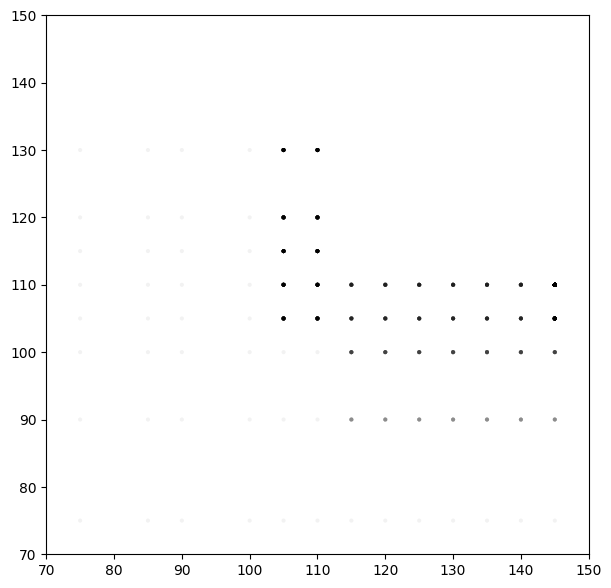

In [436]:
fig, ax = plt.subplots(figsize=(7, 7))

# df_plot = df_results[df_results["cerf_sum"] == 3]
df_plot = df_results[df_results["target_sum"] == 5]

ax.scatter(
    df_plot["wind_speed_max"],
    df_plot["wind_speed_max_landfall"],
    color="k",
    edgecolors="none",
    alpha=0.05,
    marker=".",
)
ax.set_xlim(70, 150)
ax.set_ylim(70, 150)

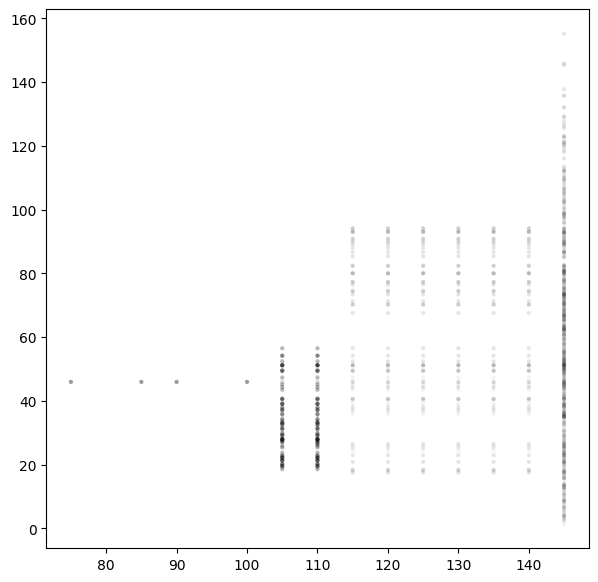

In [437]:
fig, ax = plt.subplots(figsize=(7, 7))

# df_plot = df_results[df_results["cerf_sum"] == 3]

ax.scatter(
    df_plot["wind_speed_max"],
    df_plot["rain_thresh"],
    color="k",
    edgecolors="none",
    alpha=0.05,
    marker=".",
)
# ax.set_xlim(70, 150)
# ax.set_ylim(70, 150)

In [438]:
df_results.max()

rain_col                   q99_total_mean_abv
rain_thresh                        531.149475
wind_speed_max                          145.0
wind_speed_max_landfall                 130.0
target_sum                                  5
impact_sum                           22612062
target_with_cerf_sum                        6
cerf_sum                                    3
rain_agg                             quantile
rain_q                                     99
rain_window                             total
dtype: object

<Axes: xlabel='target_with_cerf_sum'>

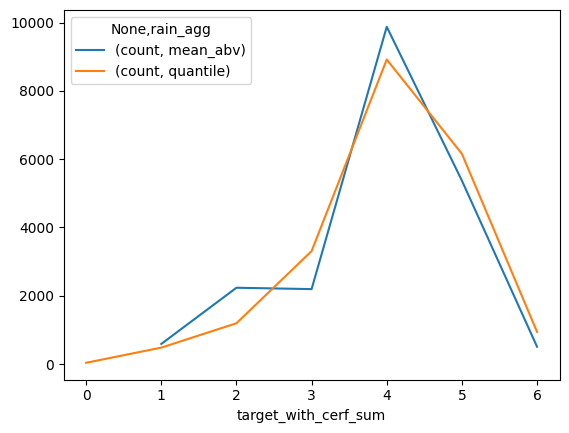

In [467]:
df_results.groupby(["rain_agg", "target_with_cerf_sum"]).size().rename(
    "count"
).reset_index().pivot(columns="rain_agg", index="target_with_cerf_sum").plot()

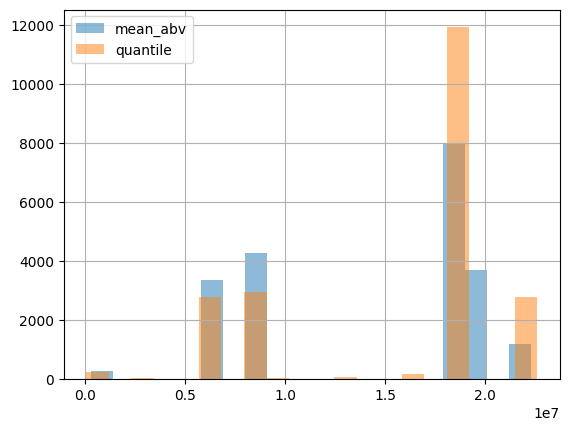

In [440]:
fig, ax = plt.subplots()

for window, group in df_results.groupby("rain_agg"):
    group["impact_sum"].hist(ax=ax, alpha=0.5, label=window, bins=20)

ax.legend()

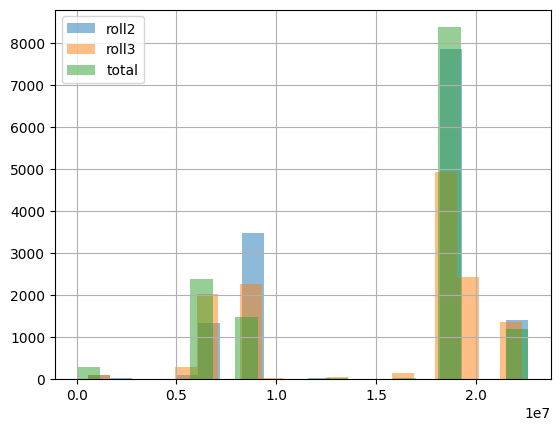

In [441]:
fig, ax = plt.subplots()

for window, group in df_results.groupby("rain_window"):
    group["impact_sum"].hist(ax=ax, alpha=0.5, label=window, bins=20)

ax.legend()

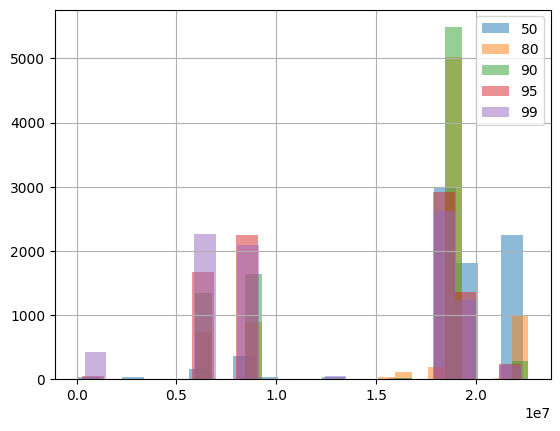

In [442]:
fig, ax = plt.subplots()

for q, group in df_results.groupby("rain_q"):
    group["impact_sum"].hist(ax=ax, alpha=0.5, label=q, bins=20)

ax.legend()

In [444]:
df_results.groupby("rain_q")[
    ["impact_sum", "cerf_sum", "target_sum", "target_with_cerf_sum"]
].mean()

,impact_sum,cerf_sum,target_sum,target_with_cerf_sum
rain_q,,,,
50,1.872799e+07,1.922340,3.592804,4.300932
80,1.683187e+07,1.891519,3.074032,4.042716
90,1.506497e+07,1.816492,2.727190,3.851391
95,1.365807e+07,1.897151,2.639792,3.862868
99,1.252712e+07,2.029757,2.771867,3.832958


In [445]:
df_results.groupby("rain_window")[
    ["impact_sum", "cerf_sum", "target_sum", "target_with_cerf_sum"]
].mean()

,impact_sum,cerf_sum,target_sum,target_with_cerf_sum
rain_window,,,,
roll2,1.523610e+07,1.944015,2.973957,4.049579
roll3,1.511703e+07,1.928006,2.920097,3.959279
total,1.541445e+07,1.862684,2.940042,3.895962


In [474]:
df_results.sort_values(["cerf_sum", "impact_sum"], ascending=False).iloc[:20]

,rain_col,rain_thresh,wind_speed_max,wind_speed_max_landfall,target_sum,impact_sum,target_with_cerf_sum,cerf_sum,rain_agg,rain_q,rain_window
11753,q80_roll2,98.341003,120.0,75.0,4,22612062,5,3,quantile,80,roll2
11754,q80_roll2,98.341003,120.0,90.0,4,22612062,5,3,quantile,80,roll2
11755,q80_roll2,98.341003,120.0,100.0,4,22612062,5,3,quantile,80,roll2
11756,q80_roll2,98.341003,110.0,75.0,4,22612062,5,3,quantile,80,roll2
11757,q80_roll2,98.341003,110.0,90.0,4,22612062,5,3,quantile,80,roll2
11758,q80_roll2,98.341003,110.0,100.0,4,22612062,5,3,quantile,80,roll2
11759,q80_roll2,98.341003,90.0,NaN,4,22612062,5,3,quantile,80,roll2
11760,q80_roll2,98.341003,90.0,115.0,4,22612062,5,3,quantile,80,roll2
11761,q80_roll2,98.341003,90.0,75.0,4,22612062,5,3,quantile,80,roll2
11762,q80_roll2,98.341003,90.0,90.0,4,22612062,5,3,quantile,80,roll2


In [451]:
df_results.sort_values(
    ["target_with_cerf_sum", "impact_sum"], ascending=False
).iloc[:20]

,rain_col,rain_thresh,wind_speed_max,wind_speed_max_landfall,target_sum,impact_sum,target_with_cerf_sum,cerf_sum,rain_agg,rain_q,rain_window
380,q50_total,24.472499,120.0,110.0,5,22289476,6,3,quantile,50,total
384,q50_total,24.472499,115.0,110.0,5,22289476,6,3,quantile,50,total
385,q50_total,24.472499,125.0,110.0,5,22289476,6,3,quantile,50,total
764,q50_total,25.622500,120.0,110.0,5,22289476,6,3,quantile,50,total
768,q50_total,25.622500,115.0,110.0,5,22289476,6,3,quantile,50,total
769,q50_total,25.622500,125.0,110.0,5,22289476,6,3,quantile,50,total
771,q50_total,22.917500,120.0,110.0,5,22289476,6,3,quantile,50,total
775,q50_total,22.917500,115.0,110.0,5,22289476,6,3,quantile,50,total
776,q50_total,22.917500,125.0,110.0,5,22289476,6,3,quantile,50,total
810,q50_total,22.997499,120.0,110.0,5,22289476,6,3,quantile,50,total


In [580]:
# optimize_col = "target_with_cerf_sum"
optimize_col = "impact_sum"
df_results_top_single_col = df_results[
    df_results[optimize_col] == df_results[optimize_col].max()
]
df_results_top_duplicates = df_results_top_single_col[
    df_results_top_single_col["impact_sum"]
    == df_results_top_single_col["impact_sum"].max()
]
df_results_top = (
    df_results_top.sort_values("rain_thresh")
    .drop_duplicates(
        subset=["wind_speed_max", "wind_speed_max_landfall", "rain_col"]
    )
    .sort_values("wind_speed_max")
    .drop_duplicates(
        subset=["rain_thresh", "wind_speed_max_landfall", "rain_col"]
    )
    .sort_values("wind_speed_max_landfall")
    .drop_duplicates(subset=["rain_thresh", "wind_speed_max", "rain_col"])
)

In [581]:
df_results_top

,rain_col,rain_thresh,wind_speed_max,wind_speed_max_landfall,target_sum,impact_sum,target_with_cerf_sum,cerf_sum,rain_agg,rain_q,rain_window
11797,q80_roll2,98.341003,75.0,75.0,4,22612062,5,3,quantile,80,roll2
17104,q90_total,150.110014,115.0,90.0,4,22612062,5,3,quantile,90,total
19914,q90_roll2,127.457985,145.0,90.0,4,22612062,5,3,quantile,90,roll2


In [569]:
# based on target_with_cerf_sum
selected_index = 11734
# based on cerf_sum
# selected_index = 11797
selected_trigger = df_results.loc[selected_index]
selected_trigger

rain_col                   q80_roll2
rain_thresh                   67.569
wind_speed_max                 115.0
wind_speed_max_landfall        105.0
target_sum                         5
impact_sum                  22289476
target_with_cerf_sum               6
cerf_sum                           3
rain_agg                    quantile
rain_q                            80
rain_window                    roll2
Name: 11734, dtype: object

In [606]:
def plot_trigger_option(selected_index):
    selected_trigger = df_results.loc[selected_index]
    rain_col = selected_trigger["rain_col"]
    rain_thresh = selected_trigger["rain_thresh"]
    wind_speed_max = selected_trigger["wind_speed_max"]
    wind_speed_max_landfall = selected_trigger["wind_speed_max_landfall"]
    df_triggered = df_stats[
        (df_stats[rain_col] >= rain_thresh)
        & (
            (df_stats["wind_speed_max"] >= wind_speed_max)
            | (df_stats["wind_speed_max_landfall"] >= wind_speed_max_landfall)
        )
    ]

    ymax = df_stats[rain_col].max() * 1.1
    xmax = df_stats["wind_speed_max"].max() * 1.1

    fig, ax = plt.subplots(dpi=200, figsize=(7, 7))

    bubble_sizes = df_stats["Total Affected"].fillna(0)
    # Optional: scale for visual clarity
    bubble_sizes_scaled = (
        bubble_sizes / bubble_sizes.max() * 5000
    )  # Adjust 300 as needed

    # Plot bubbles
    ax.scatter(
        df_stats["wind_speed_max"],
        df_stats[rain_col],
        s=bubble_sizes_scaled,
        alpha=0.3,
        color="crimson",
        edgecolor="none",
        zorder=1,
    )

    for _, row in df_stats.iterrows():
        triggered = row["sid"] in df_triggered["sid"].to_list()
        ax.annotate(
            row["name"].capitalize() + "\n" + str(row["season"]),
            (row["wind_speed_max"], row[rain_col]),
            ha="center",
            va="center",
            fontsize=6,
            color="crimson" if row["cerf"] == True else "k",
            zorder=10 if row["cerf"] else 9,
            alpha=0.8,
            fontstyle="italic" if triggered else "normal",
            fontweight="bold" if triggered else "normal",
        )

    trig_color = "gold"
    ax.axvline(
        wind_speed_max,
        color=trig_color,
        linewidth=0.5,
        zorder=0,
    )
    ax.axvline(
        wind_speed_max_landfall,
        color=trig_color,
        linewidth=0.5,
        linestyle="--",
        zorder=0,
    )
    ax.axhline(
        rain_thresh,
        color=trig_color,
        linewidth=0.5,
        zorder=0,
    )
    ax.add_patch(
        mpatches.Rectangle(
            (wind_speed_max, rain_thresh),  # bottom left
            xmax - wind_speed_max,  # width
            ymax - rain_thresh,  # height
            facecolor=trig_color,
            alpha=0.1,
            zorder=0,
        )
    )

    for cat_value, cat_name in CAT_LIMITS:
        ax.annotate(
            cat_name + " -",
            (cat_value, 0),
            fontstyle="italic",
            color="grey",
            rotation=90,
            va="top",
            ha="center",
            fontsize=8,
        )

    ax.set_ylabel(rain_col)
    ax.set_xlabel("\nMax. wind speed while in ZMA (knots)")

    ax.set_xlim(left=0, right=xmax)
    ax.set_ylim(bottom=0, top=ymax)

    ax.spines.top.set_visible(False)
    ax.spines.right.set_visible(False)

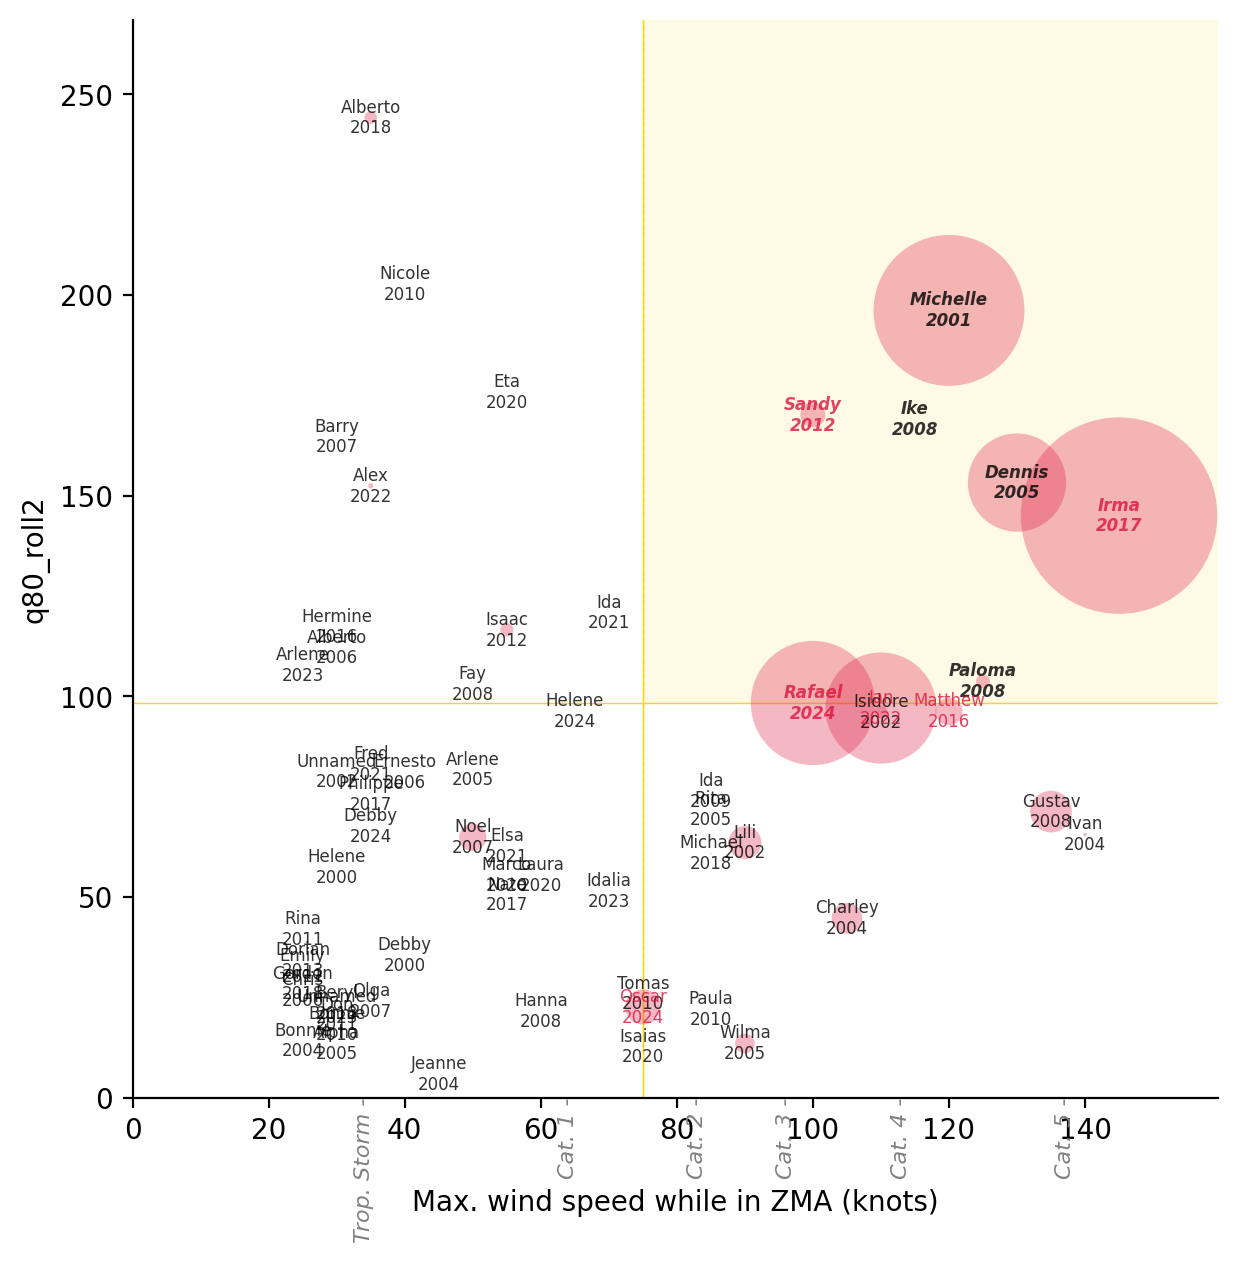

In [607]:
# based on cerf_sum
selected_index = 11797
plot_trigger_option(selected_index)

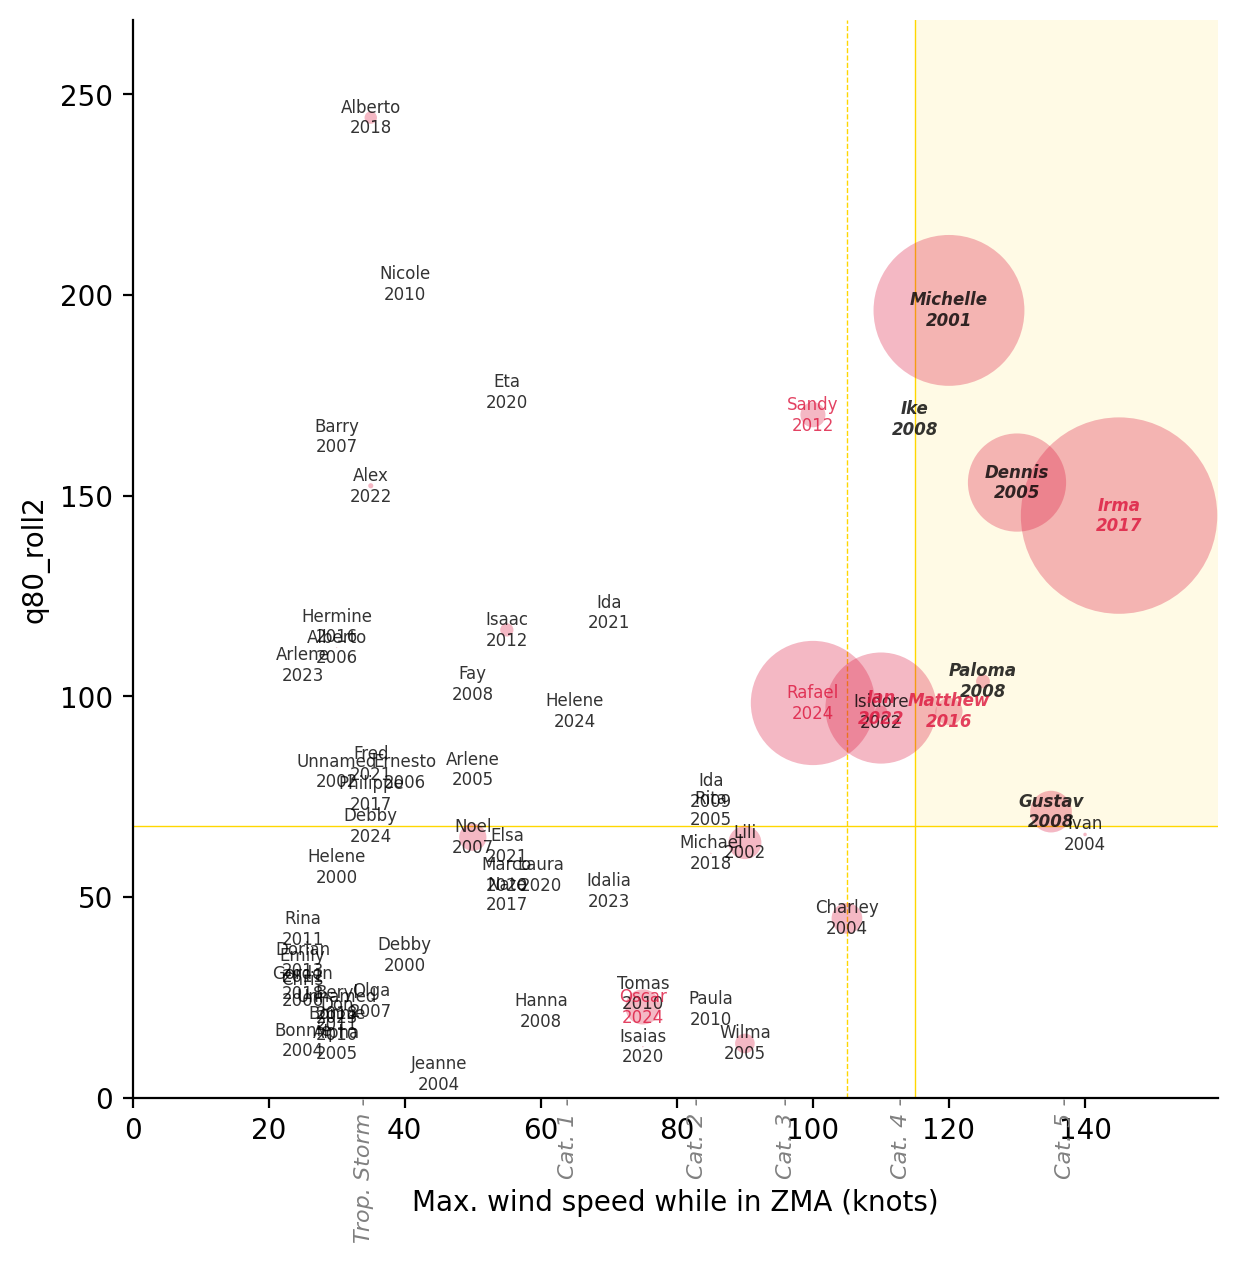

In [608]:
# based on target_with_cerf_sum
selected_index = 11734
plot_trigger_option(selected_index)